In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb

In [2]:
engine =create_engine('sqlite:///../Data/Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [3]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2020-07-15,-0.98,1.39,Utah,39.691964,-111.759634,2.679091,1.392000,0.214286,1.011818,1.172000,1.438571,0
1,2020-07-15,-0.97,1.17,Utah,39.691964,-111.759634,2.290455,0.777333,0.292857,1.044091,1.217333,1.398571,0
2,2020-07-15,6.69,0.15,Utah,39.691964,-111.759634,2.192273,0.652000,1.394286,1.034545,1.201333,1.245714,0
3,2020-07-15,-2.19,1.39,Utah,39.691964,-111.759634,1.694545,0.576000,1.300000,1.057273,1.180667,1.232857,0
4,2020-07-15,-1.83,1.44,Utah,39.691964,-111.759634,1.350000,0.558000,1.185714,1.112727,1.188667,1.254286,0


In [4]:
engine =create_engine('sqlite:///../Data/Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [5]:
# Live data to be predicted on after being trained of rolling period for next 7 days. 
#Hence NaN outcome that has to be predicted

df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2020-08-02,10.00,4.30,Tonga,-17.385943,-174.537900,117.841818,100.370000,151.860000,4.645455,4.640000,4.700000,NaN
1,2020-08-03,90.47,5.20,Tonga,-17.385943,-174.537900,121.499545,104.069333,163.355714,4.677273,4.660000,4.628571,NaN
2,2020-08-10,-0.52,1.74,Oregon,44.044683,-122.684228,6.032727,3.482000,2.627143,1.413182,1.245333,1.051429,NaN
3,2020-08-10,13.78,1.40,Oregon,44.044683,-122.684228,5.577273,4.082667,4.664286,1.412273,1.266667,1.084286,NaN
4,2020-07-30,10.00,4.80,India,22.270152,93.567868,14.375000,13.063333,12.481429,4.709091,4.793333,4.600000,NaN


In [6]:
# Selection of features that are needed for prediction and hence consider only them rest are just ignored for prediction purpose.

features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

# splitting traing and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)
  

In [7]:
X_test

,depth,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7
1722,11.90,8.504545,8.980000,10.228571,1.090909,1.106667,1.285714
12139,18.26,11.029091,11.699333,17.540000,0.705455,0.602000,0.372857
11726,86.10,25.152273,21.320667,36.138571,1.413636,0.980000,0.708571
1282,10.60,11.681818,12.633333,13.814286,1.400000,1.333333,1.242857
5015,14.14,6.059091,6.736000,7.125714,0.724545,0.778667,0.834286
...,...,...,...,...,...,...,...
9380,2.20,26.205909,29.456000,29.657143,1.271364,1.524667,1.657143
3148,9.77,7.293636,7.704667,8.211429,0.755000,0.780000,0.728571
3685,7.06,6.638636,6.608667,7.621429,0.982727,0.888000,1.178571
10254,32.40,25.096818,26.082000,36.021429,1.431364,1.512667,1.645714


In [8]:
 y_test

1722     0
12139    0
11726    0
1282     0
5015     0
        ..
9380     0
3148     0
3685     0
10254    0
10980    0
Name: mag_outcome, Length: 3803, dtype: int64

In [9]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

#### Adaboost Decision Tree Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              "base_estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

#### Parameter tunning with GridSearch CV

In [11]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [12]:
grid_search_ABC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\

C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [13]:
pred_ABC=grid_search_ABC.predict(X_test)

0.8929346912270325
AUC: 0.8929


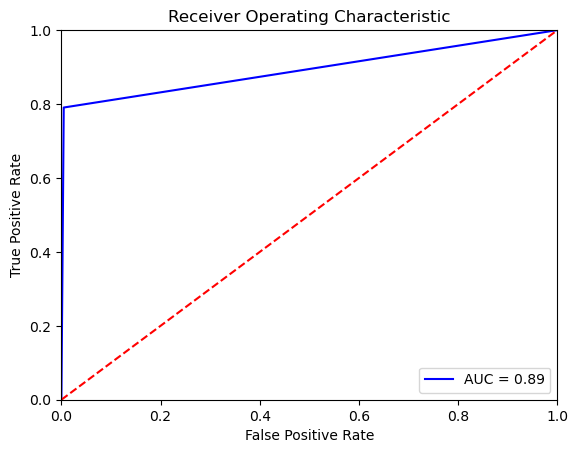

Confusion Matrix: 
 [[3595   17]
 [  40  151]]

Recall 'TP/TP+FN' =  0.7905759162303665


In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, pred_ABC))

fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred_ABC))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred_ABC))

#### Adaboost Random Forest Classifier

In [15]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\lenovo\anaconda3\Lib\site-pack

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [16]:
pred=CV_rfc.predict(X_test)

0.9022984757034435
AUC: 0.9023


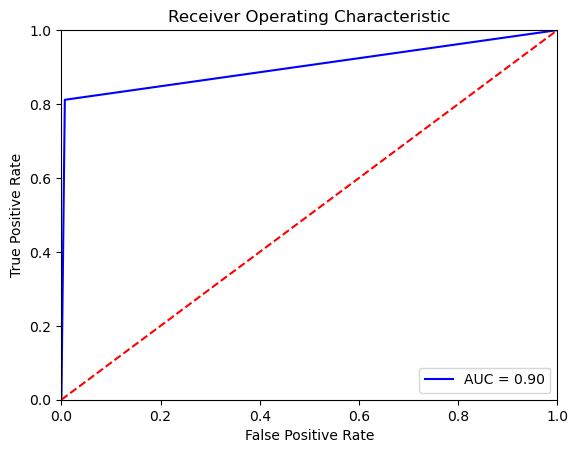

Confusion Matrix: 
 [[3587   25]
 [  36  155]]

Recall 'TP/TP+FN' =  0.8115183246073299


In [17]:

print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred))

In [18]:
from sklearn.metrics import roc_curve, auc

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.003,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset
num_round = 5000  # the number of training iterations    
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

ypred_bst = np.array(bst.predict(dtest,ntree_limit=bst.best_iteration))
ypred_bst  = ypred_bst > 0.5
ypred_bst = ypred_bst.astype(int)  

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("Confusion Matrix: \n",confusion_matrix(y_test,ypred_bst))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,ypred_bst))

C:\Users\lenovo\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:19:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


0.9814768108631496
AUC: 0.9815


AttributeError: `best_iteration` is only defined when early stopping is used.

In [ ]:

dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(preds)
plt.show()

In [ ]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()

objects = ('adboost random forest','adboost decsion tree','xgboost')
y_pos = np.arange(len(objects))
performance = [0.90,0.89,0.98]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('AR vs AD vs XGBOOST')

plt.show()

In [ ]:
test_vector = np.reshape(np.asarray([4.040000,51.852273,53.176667,62.348571,1.408636,1.492667,1.227143]),(1,7))
p = int(xgb.predict(test_vector)[0])
p